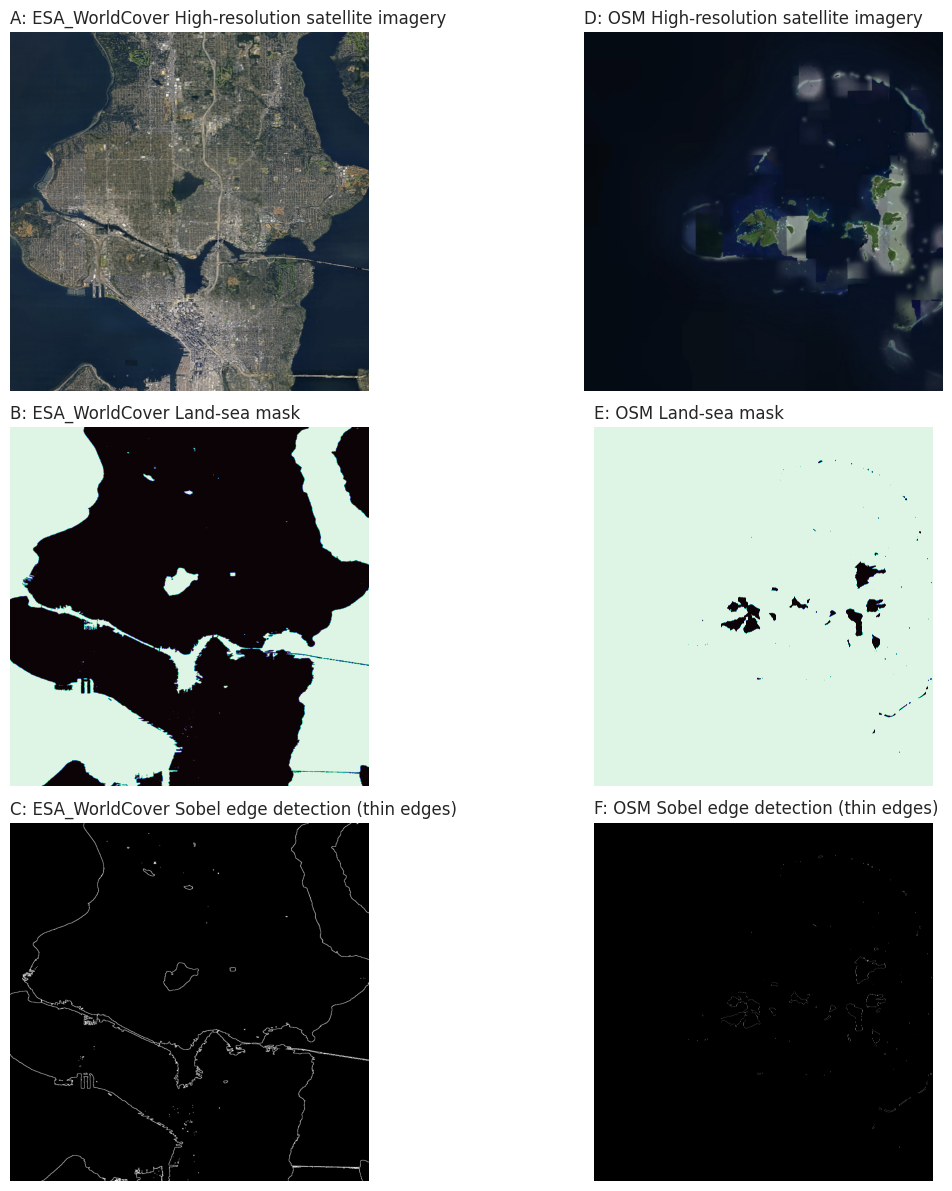

In [ ]:
import seaborn as sns
from skimage.filters import sobel
from skimage.morphology import thin

sns.set_theme(style="white", context="paper")

def load_and_plot_images_with_zoom_regions(h5_path1, png_path1, zoom_region1, title_prefix1,
                                           h5_path2, png_path2, zoom_region2, title_prefix2):
    """
    Load and plot images for two datasets (satellite imagery, land-sea mask, Sobel edge detection).
    Ensures square aspect ratios and arranges plots in two columns. Sobel edges are shown as thin lines.
    """

    from skimage.filters import sobel
    from skimage.util import img_as_float

    def sobel_edges_thin(img: np.ndarray) -> np.ndarray:
        """Edge detection using Sobel filter with thin edges on a white background."""
        # Ensure input is float for proper Sobel operation
        img_float = img_as_float(img)

        # Apply Sobel filter
        sobel_edges = sobel(img_float)

        # Normalize to range [0, 1]
        sobel_edges /= sobel_edges.max()

        # Apply threshold to highlight edges
        edge_binary = sobel_edges > 0.2  # Adjust this threshold for sensitivity

        # Keep edges black and background white
        return edge_binary.astype(float)  # 0 for white, 1 for black'

    def process_single_group(axs, col_index, h5_path, png_path, zoom_region, title_prefix, letters):
        # Open the H5 file for land/sea mask and edge detection
        with h5py.File(str(h5_path), "r") as hdf:
            # Load binary data and geotransform
            band_data = hdf["band_data"][:]
            geotransform = hdf["geotransform"][:6]

            # Convert image to binary (assuming water is marked with 80)
            binary_image = np.where(band_data == 80, 1, 0)

            # Apply Sobel edge detection with thin edges
            edge_image = sobel_edges_thin(binary_image)

            # Extract zoomed region for both binary and edge images
            binary_zoom = binary_image[zoom_region]
            edge_zoom = edge_image[zoom_region]

        # Load PNG image
        png_image = Image.open(png_path)

        # Titles
        titles = [
            f"High-resolution satellite imagery",
            f"{letters[1]}: {title_prefix} Land-sea mask",
            f"{letters[2]}: {title_prefix} Sobel edge detection (thin edges)"
        ]

        # Plot high-resolution imagery
        axs[0, col_index].imshow(png_image)
        axs[0, col_index].set_title(titles[0], fontsize=12, loc="left")
        axs[0, col_index].axis('off')
        axs[0, col_index].set_aspect('equal')

        # Plot land-sea mask
        cmap = sns.color_palette("mako", as_cmap=True)  # Modern, colorblind-friendly colormap
        axs[1, col_index].imshow(binary_zoom, cmap=cmap)
        axs[1, col_index].set_title(titles[1], fontsize=12, loc="left")
        axs[1, col_index].axis('off')
        axs[1, col_index].set_aspect('equal')

        # Plot Sobel edge detection (thin edges)
        axs[2, col_index].imshow(edge_zoom, cmap='gray')
        axs[2, col_index].set_title(titles[2], fontsize=12, loc="left")
        axs[2, col_index].axis('off')
        axs[2, col_index].set_aspect('equal')

    # Set up the figure for two columns (3 rows per column)
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)

    # Process each dataset
    process_single_group(axs, 0, h5_path1, png_path1, zoom_region1, title_prefix1, ["A", "B", "C"])
    process_single_group(axs, 1, h5_path2, png_path2, zoom_region2, title_prefix2, ["D", "E", "F"])

    # Tighten layout and show the plot
    plt.tight_layout()
    plt.show()


# Example usage
load_and_plot_images_with_zoom_regions(
    'data/resampled_h5s/Ai2_WorldCover_10m_2024_v1_N47W123_Map.h5', 'seattle_high_res.png', (slice(3000, 5000), slice(7000, 9000)), "ESA_WorldCover",
    'data/resampled_h5s/Ai2_WorldCover_10m_2024_v1_N07E151_Map.h5', 'maldives_high_res_sat.png', (slice(3000, 12000), slice(3500, 12500)), "OSM"
)


In [ ]:
import numpy as np
import pandas as pd
import rasterio
from sklearn.neighbors import BallTree
from tqdm import tqdm
from typing import Tuple
from osgeo import gdal
from multiprocessing import Pool

# Load the coastal data with explicit conversion to numeric
coastal_data = pd.read_csv(
    'src/coastal_data_points/Ai2_WorldCover_10m_2024_v1_N07E151_Map_coastal_points.csv',
    header=None, names=['longitude', 'latitude']
)

# Path to the GeoTIFF
geotiff_path = 'data/resampled/Ai2_WorldCover_10m_2024_v1_N07E151_Map.tif'

# Ensure numeric coastal data
coastal_data['longitude'] = pd.to_numeric(coastal_data['longitude'], errors='coerce')
coastal_data['latitude'] = pd.to_numeric(coastal_data['latitude'], errors='coerce')
coastal_data.dropna(inplace=True)

# Convert coastal data to radians and create the BallTree
coastal_data_rad = np.radians(coastal_data[['latitude', 'longitude']].values)
tree = BallTree(coastal_data_rad, metric='haversine')

# Load the GeoTIFF and generate a grid of all latitude and longitude points
lon_array, lat_array = get_geo_arrays(geotiff_path)
lat_lon_rad = np.radians(np.column_stack((lat_array.ravel(), lon_array.ravel())))

# Define Haversine function to convert radians to meters
EARTH_RADIUS = 6371000
def haversine_dist(radian_coords, nearest_coords):
    """Compute Haversine distance between two points in radians."""
    if radian_coords.ndim == 1:
        radian_coords = radian_coords.reshape(1, -1)
    if nearest_coords.ndim == 1:
        nearest_coords = nearest_coords.reshape(1, -1)

    lat1, lon1 = radian_coords[:, 0], radian_coords[:, 1]
    lat2, lon2 = nearest_coords[:, 0], nearest_coords[:, 1]
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

# Function to process each batch of points
def process_batch(batch):
    dist, ind = tree.query(batch, k=1)
    nearest_coords = coastal_data_rad[ind.flatten()]
    return haversine_dist(batch, nearest_coords)

# Process the entire set of points in parallel
with Pool(processes=150) as pool:
    # Split data into manageable batches
    results = [pool.apply_async(process_batch, (batch,)) for batch in np.array_split(lat_lon_rad, 150)]

    # Retrieve and concatenate results with progress tracking
    distances = np.concatenate([r.get() for r in tqdm(results, desc="Collecting results")])

# Reshape distances to match the original raster shape and save
output_data = distances.reshape(lat_array.shape)
np.save("Ai2_WorldCover_10m_2024_v1_N07E151_Map_coastal_points_distances.npy", output_data)


In [ ]:
from sklearn.neighbors import BallTree
import joblib
import numpy as np
# Assuming coastal_data_rad is already created as an array of coordinates in radians
tree = BallTree(coastal_data_rad, metric='haverzsine')

# Save the BallTree
joblib.dump(tree, 'coastal_data_balltree.joblib')


# To load the BallTree quickly
tree = joblib.load('coastal_data_balltree.joblib')

NameError: name 'coastal_data_rad' is not defined

In [ ]:
def load_tree():
    tree = joblib.load('coastal_data_balltree.joblib')
    tree.query([[0,1]], k=1)


In [29]:
%timeit load_tree()

633 μs ± 2.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
